In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../../")


from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [4]:
import tensorflow as tf
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.experimental.net2net_v3 import Net2Net
import tensorflow_addons as tfa
from datetime import datetime
from tqdm.auto import tqdm
from pyprojroot.pyprojroot import here

tf.get_logger().setLevel('WARNING')
import warnings
warnings.filterwarnings('ignore')

2022-07-13 00:27:34.421221: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 00:27:34.817628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22297 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


In [6]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/kny_transformer_light.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = cfg["train"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["train"]["n_epochs"]
sample_batch_size = 8

In [8]:
dataset_length = 689
num_batch = dataset_length / batch_size

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    first_frame = element[0,...]
    last_frame = element[2,...]
    
    y = element[0:3,...]
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

In [9]:
drop_prob = 0.0 #0.2

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    #num_elements_to_keep = tf.random.uniform(shape=(1,), minval=5, maxval=tf.shape(element)[0], dtype=tf.int32)
    #remainder = tf.shape(element)[0] - num_elements_to_keep[0]
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    
    #element = element[:10,...]
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

def video_to_ragged(element):
    element["y"] = tf.RaggedTensor.from_tensor(tf.expand_dims(element["y"], 0))
    return element
def squeeze_ragged(element):
    element["y"] = tf.squeeze(element["y"], axis=1)
    return element
def to_tensor(element):
    element["y"] = element["y"].to_tensor()
    return element

dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           #.map(video_to_ragged, num_parallel_calls=tf.data.AUTOTUNE)
           )

train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

train_ds = dataset.take(train_size)#.batch(global_batch_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.batch(global_batch_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.batch(global_batch_size)

train_sample_data = next(train_ds
                          .padded_batch(batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(batch_size).as_numpy_iterator())

train_ds = (train_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))

In [10]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    n_frames = tf.shape(element)[0]
    
    remaining_frames = tf.reverse(tf.range(n_frames), axis=[0])
    
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    remaining_frames = remaining_frames[idx_to_keep]
    
    element = element[:10,...]
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0], "remaining_frames": remaining_frames}
def postprocess(batch):
    min_frames = tf.reduce_min(batch["n_frames"])
    first_frame_idx = tf.constant(0)
    frames_to_keep = min_frames - 2
    
    y = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    remaining_frames = tf.TensorArray(tf.int32, size=0, dynamic_size=True, clear_after_read=False)
    
    for i in tf.range(tf.shape(batch["y"])[0]):
        num_frames = batch["n_frames"][i]
        last_frame_idx = num_frames - 1
        all_indices = tf.range(1, num_frames - 1)
        indices = tf.sort(tf.random.shuffle(all_indices)[:frames_to_keep])
        indices = tf.concat([[first_frame_idx], indices, [last_frame_idx]], axis=0)
        y = y.write(i, tf.gather(batch["y"][i], indices))
        remaining_frames = remaining_frames.write(i, tf.gather(batch["remaining_frames"][i], indices))
        
    batch["remaining_frames"] = remaining_frames.stack()
    batch["y"] = y.stack()
    batch["n_frames"] = tf.repeat(min_frames, tf.shape(batch["y"])[0])
    
    return batch

In [11]:
dataset = VideoDataset("../../../data/kny/videos_tfrecords_light").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           )

In [12]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [13]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [14]:
train_sample_data = next(train_ds
                          .padded_batch(sample_batch_size).map(postprocess)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(sample_batch_size).map(postprocess).as_numpy_iterator())

In [15]:
train_ds = (train_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

In [16]:
train_sample_data["n_frames"]

array([7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)

[]

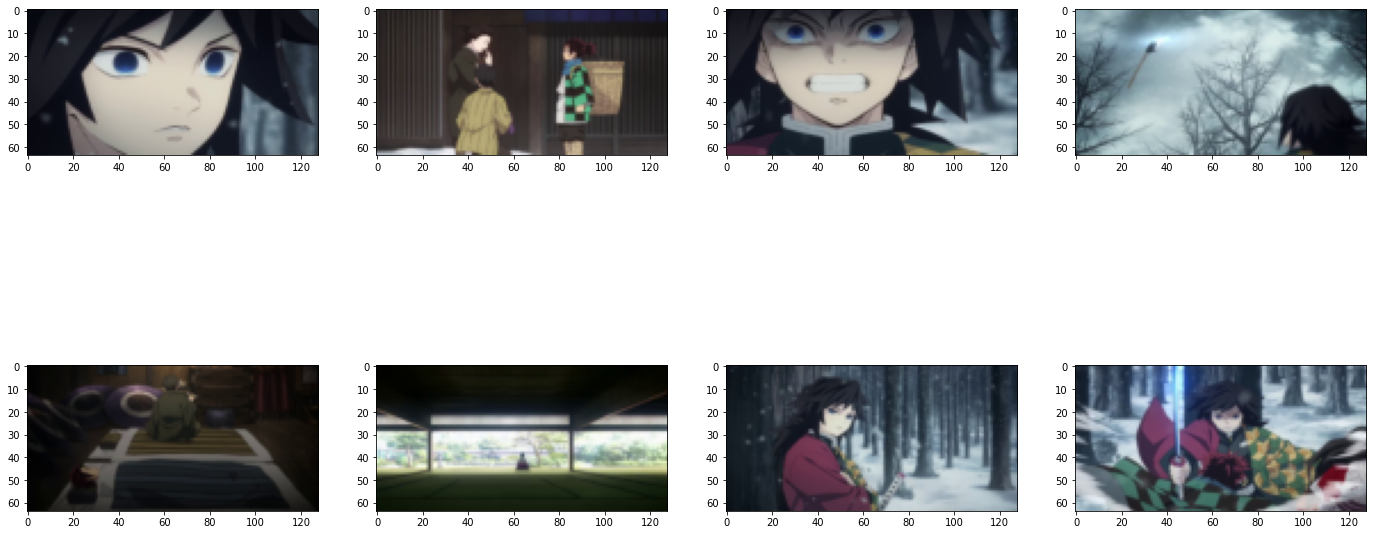

In [17]:
display_images(train_sample_data["first_frame"], 2, 4)
plt.plot()

In [19]:
display_videos(train_sample_data["y"], 2, 4)

train_ds = strategy.experimental_distribute_dataset(train_ds)
validation_ds = strategy.experimental_distribute_dataset(validation_ds)
test_ds = strategy.experimental_distribute_dataset(test_ds)

In [20]:
from ganime.utils.callbacks import TensorboardVideo, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/transformers", experiment_name="mnist_video")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_video_callback = TensorboardVideo(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_total_loss', save_best_only=True, save_weights_only=True)
#callbacks = [tensorboard_callback, early_stopping, checkpointing, tensorboard_video_callback]
callbacks = [tensorboard_callback, checkpointing, tensorboard_video_callback]

In [21]:
images = train_sample_data["y"][:,0,...]

In [22]:
train_sample_data["y"].shape

(8, 7, 64, 128, 3)

In [23]:
with strategy.scope():
    model = Net2Net(**cfg["model"], trainer_config=cfg["train"], num_replicas=strategy.num_replicas_in_sync)
    #model.build(train_sample_data["y"].shape)#first_stage_model.build(train_sample_data["y"].shape[1:])
    model.first_stage_model.build(train_sample_data["y"].shape[1:])

Working with z of shape (1, 128, 8, 8) = 8192 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.


2022-07-13 00:28:36.711942: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-13 00:28:37.272717: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [24]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [25]:
print_gpu_utilization()

GPU memory occupied: 7286 MB.


for i in range(10):
    pbar = tqdm(train_ds)
    for data in pbar:
        output = strategy.run(model.train_step, args=(data,))
        pbar.set_postfix(loss=output["loss"].numpy())

In [26]:
model.fit(train_ds, validation_data=validation_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)
#model.fit(train_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)

Epoch 1/100


2022-07-13 00:29:22.105822: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


     68/Unknown - 88s 767ms/step - total_loss: 9.5283 - scce_loss: 6.9394 - perceptual_loss: 2.5890

2022-07-13 00:30:24.357632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'net2_net/StatefulPartitionedCall/while/body/_678/while/StatefulPartitionedCall/Identity_1' -> 'net2_net/StatefulPartitionedCall/while/body/_678/while/transformer/concat', 'net2_net/StatefulPartitionedCall/while/body/_678/while/Identity_7' -> 'net2_net/StatefulPartitionedCall/while/next_iteration/_1268', 'net2_net/StatefulPartitionedCall/while/body/_678/while/transformer/strided_slice_2/stack' -> 'net2_net/StatefulPartitionedCall/while/body/_678/while/transformer/strided_slice_2'}.
2022-07-13 00:30:47.917472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'while/body/_102/while/StatefulPartitionedCall/Identity_1' -> 'while/body/_102/while/transformer/concat', 'whil

68/68 [==============================] - 129s 1s/step - total_loss: 9.5283 - scce_loss: 6.9394 - perceptual_loss: 2.5890 - val_total_loss: 8.5026 - val_scce_loss: 5.8793 - val_perceptual_loss: 2.6234
Epoch 2/100
68/68 [==============================] - 72s 1s/step - total_loss: 8.7240 - scce_loss: 4.5416 - perceptual_loss: 4.1825 - val_total_loss: 8.1137 - val_scce_loss: 3.6411 - val_perceptual_loss: 4.4726
Epoch 3/100
68/68 [==============================] - 71s 1s/step - total_loss: 7.0158 - scce_loss: 3.6811 - perceptual_loss: 3.3347 - val_total_loss: 6.8275 - val_scce_loss: 3.7009 - val_perceptual_loss: 3.1265
Epoch 4/100
68/68 [==============================] - 72s 1s/step - total_loss: 4.5750 - scce_loss: 2.8984 - perceptual_loss: 1.6766 - val_total_loss: 4.9222 - val_scce_loss: 3.0351 - val_perceptual_loss: 1.8871
Epoch 5/100
68/68 [==============================] - 71s 1s/step - total_loss: 2.7885 - scce_loss: 1.9800 - perceptual_loss: 0.8086 - val_total_loss: 3.6985 - val_scce

In [ ]:
generated_videos = model(train_sample_data, training=False)

In [ ]:
display_videos(generated_videos, 1, 4)

In [ ]:
display_videos(train_sample_data["y"], 1, 4)

In [ ]:
quant_z, indices = model.encode_to_z(images)

In [ ]:
quant = model.first_stage_model.quantize.get_codebook_entry(
    indices, shape=tf.shape(quant_z)
)
decoded = model.first_stage_model.decode(quant)

In [ ]:
display_images(model.first_stage_model(images)[0])
plt.show()

In [ ]:
display_images(generated_videos[:,0,...])

In [101]:
import glob
from typing import Optional, Tuple

import click
import numpy as np
import tensorflow as tf
from ganime.data.experimental import VideoDataset
from joblib import Parallel, delayed
from tqdm.auto import tqdm

video_extensions = ["mp4", "mkv", "avi"]


def load_npy(path: str) -> np.ndarray:
    images = np.load(path)
    return images


def get_filepaths(path: str, extension: str) -> list:
    filepaths = sorted(glob.glob(f"{path}/*.{extension}"))
    if len(filepaths) == 0:
        raise ValueError(f"No files found in {path} with the extension {extension}")
    return filepaths


def get_value_to_split(
    video: np.ndarray, min_ideal_length: int, max_ideal_length: int
) -> int:
    n_elements = video.shape[0]

    lowest_remainder = max_ideal_length
    lowest_id = max_ideal_length
    for i in range(min_ideal_length, max_ideal_length):
        remainder = n_elements % i
        if remainder <= lowest_remainder:
            lowest_id = i
            lowest_remainder = remainder
    return lowest_id


def cut_long_video(video, length):
    n_splits = video.shape[0] // length
    if n_splits == 0:
        yield video
    else:
        for i in range(n_splits):
            start = i * length
            end = (i + 1) * length
            if video.shape[0] - end < length:
                end = video.shape[0]
            yield video[start:end]


def load_videos(
    path: str,
    extension: str,
    resize: Optional[Tuple[int, int]],
    min_ideal_length: int,
    max_ideal_length: int,
    n_jobs: int,
) -> np.ndarray:
    assert (
        extension in video_extensions
    ), f"Extension {extension} must be one of {video_extensions}"

    video_paths = get_filepaths(path, extension)
    print("loading videos...")
    videos = Parallel(n_jobs=n_jobs)(
        delayed(load_and_resize_video)(path, resize, min_ideal_length, max_ideal_length)
        for path in tqdm(video_paths[150:160])
    )
    videos = tf.concat(videos, axis=0)
    videos = videos.numpy()
    return videos


def load_and_resize_video(
    image_path: str,
    resize: Optional[Tuple[int, int]],
    min_ideal_length: int,
    max_ideal_length: int,
) -> np.array:
    import skvideo.io

    videos = []
    video = skvideo.io.vread(image_path)
    if resize is not None:
        height, width = resize
        video = resize_images(video, width, height)
        
    if True:
        video = video[2:]
        
    video = video[::2]

    for video_split in cut_long_video(
        video, get_value_to_split(video, min_ideal_length, max_ideal_length)
    ):
        videos.append(video_split)

    videos = tf.ragged.stack([tf.convert_to_tensor(video) for video in videos], axis=0)

    return videos


def resize_images(images: np.ndarray, width: int, height: int) -> np.ndarray:
    import skimage.transform

    n_images = images.shape[0]
    resized_images = np.zeros((n_images, height, width, 3), dtype=np.uint8)
    # print("resizing images...")
    for i in range(n_images):
        resized = skimage.transform.resize(
            images[i], (height, width), anti_aliasing=True
        )
        resized = (resized * 255).astype(np.uint8)
        resized_images[i] = resized
    return resized_images

In [102]:
videos = load_videos("../../../data/kny/scenes/01", extension="mp4", resize=(64, 128), min_ideal_length=15, max_ideal_length=25, n_jobs=1)

loading videos...


  0%|          | 0/10 [00:00<?, ?it/s]

In [110]:
display_videos(np.expand_dims(videos[3], axis=0), 1, 1)